In [1]:
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
from scipy import stats

In [2]:
%config Inline.figure_format = 'retina'
az.style.use('arviz-darkgrid')
az.rcParams['stats.credible_interval'] = 0.89  # set credible interval for entire notebook
az.rcParams['stats.information_criterion'] = 'waic'  # set information criterion to use in `compare`
az.rcParams['stats.ic_scale'] = 'deviance'    # set information criterion scale
np.random.seed(0)

#### Code 8.1

In [3]:
d = pd.read_csv("Data/rugged.csv", delimiter=";")

# make log version of the outcome
d["log_gdp"] = np.log(d["rgdppc_2000"])

# extract countries with GDP data
dd = d.dropna(subset=["log_gdp"])

# rescale variables
dd["log_gdp_std"] = dd["log_gdp"] / dd["log_gdp"].mean()
dd["rugged_std"] = dd["rugged"] / dd["rugged"].max()

/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


#### Code 8.2

In [4]:
with pm.Model() as m_8_1:
    a = pm.Normal("a", 1, 1)
    b = pm.Normal("b", 0, 1)

    mu = a + b * (dd["rugged_std"] - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, shape=dd.shape[0])

#### Code 8.3

In [5]:
with m_8_1:
    m_8_1_prior = pm.sample_prior_predictive()

# Figure 8.3 is below

#### Code 8.4

In [6]:
np.sum(np.abs(m_8_1_prior["b"] > 0.6)) / len(m_8_1_prior["b"])

0.23

#### Code 8.5

In [7]:
with pm.Model() as m_8_1t:
    a = pm.Normal("a", 1, 0.1)
    b = pm.Normal("b", 0, 0.3)

    mu = a + b * (dd["rugged_std"] - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"])

    m_8_1t_trace = pm.sample()

    m_8_1t_prior = pm.sample_prior_predictive()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1491.90draws/s]


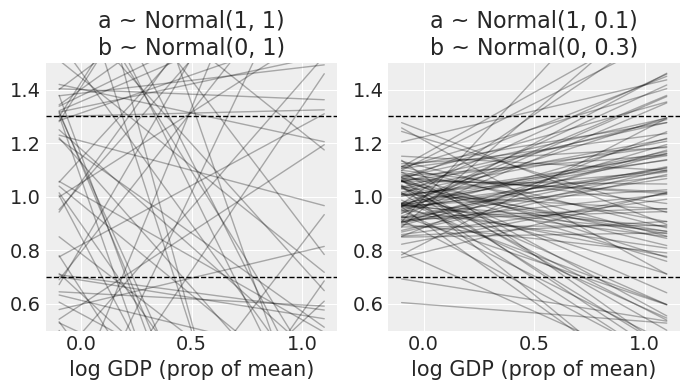

In [8]:
# Figure 8.3

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[7, 4])

n = 100
rugged_plot = np.linspace(-0.1, 1.1)
ax1.plot(
    rugged_plot,
    m_8_1_prior["a"][:n].T + rugged_plot.reshape(-1, 1) * m_8_1_prior["b"][:n].T,
    color="k",
    lw=1,
    alpha=0.3,
)
ax1.set_title("a ~ Normal(1, 1)\nb ~ Normal(0, 1)")

ax2.plot(
    rugged_plot,
    m_8_1t_prior["a"][:n].T + rugged_plot.reshape(-1, 1) * m_8_1t_prior["b"][:n].T,
    color="k",
    lw=1,
    alpha=0.3,
)
ax2.set_title("a ~ Normal(1, 0.1)\nb ~ Normal(0, 0.3)")

for ax in (ax1, ax2):
    ax.set_xlabel("ruggedness")
    ax.set_xlabel("log GDP (prop of mean)")
    ax.axhline(0.7, ls="dashed", color="k", lw=1)
    ax.axhline(1.3, ls="dashed", color="k", lw=1)
    ax.set_ylim(0.5, 1.5)

fig.tight_layout()

#### Code 8.6

In [9]:
az.summary(m_8_1t_trace, kind="stats", round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%
a,1.00,0.01,0.98,1.01
b,0.00,0.06,-0.09,0.08
sigma,0.14,0.01,0.13,0.15


#### Code 8.7

In [10]:
cid = pd.Categorical(dd["cont_africa"])

#### Code 8.8

In [11]:
with pm.Model() as m_8_2:
    a = pm.Normal("a", 1, 0.1, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3)

    mu = a[cid] + b * (dd["rugged_std"] - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"])

    m_8_2_trace = pm.sample()

/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████

#### Code 8.9

In [12]:
az.compare({"m_8_1t": m_8_1t_trace, "m_8_2": m_8_2_trace})

/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/arviz/stats/stats.py:1210: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m_8_2,0,-252.28,4.12419,0,0.999949,13.1613,0,True,deviance
m_8_1t,1,-188.94,2.50624,63.3395,5.13188e-05,14.39,14.6279,False,deviance


#### Code 8.10

In [13]:
az.summary(m_8_2_trace, kind="stats", round_to=2)

/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hpd_5.5%,hpd_94.5%
a[0],1.05,0.01,1.03,1.07
a[1],0.88,0.02,0.86,0.91
b,-0.04,0.04,-0.12,0.02
sigma,0.11,0.01,0.10,0.12


#### Code 8.11

In [14]:
with m_8_2:
    m_8_2_posterior = pm.sample_posterior_predictive(m_8_2_trace, vars=[a, b, sigma])

diff_a0_a1 = m_8_2_posterior["a"][:, 1] - m_8_2_posterior["a"][:, 0]

az.hpd(diff_a0_a1)

100%|██████████| 1000/1000 [00:00<00:00, 10275.22it/s]


array([-0.19784896, -0.13946415])

#### Code 8.12

Text(0, 0.5, 'log GDP (as proportion of mean)')

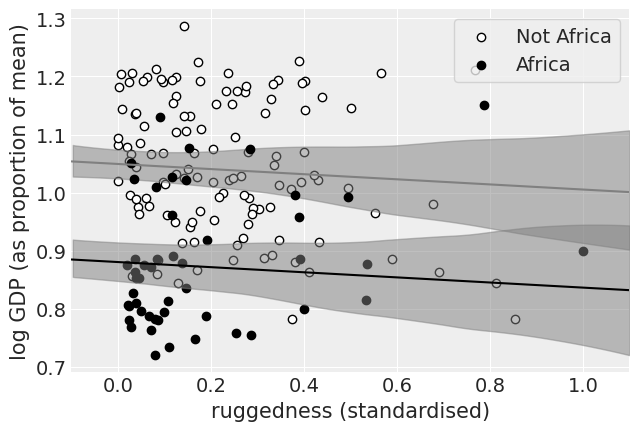

In [15]:
fig, ax = plt.subplots()

rugged_plot = np.linspace(-0.1, 1.1)

ax.scatter(
    dd.loc[cid == 0, "rugged_std"],
    dd.loc[cid == 0, "log_gdp_std"],
    label="Not Africa",
    facecolor="w",
    lw=1,
    edgecolor="k",
)

pred0 = m_8_2_posterior["a"][:, 0] + rugged_plot.reshape(-1, 1) * m_8_2_posterior["b"]
ax.plot(rugged_plot, pred0.mean(1), color="grey")
az.plot_hpd(rugged_plot, pred0.T, color="grey", credible_interval=0.97)

ax.scatter(
    dd.loc[cid == 1, "rugged_std"],
    dd.loc[cid == 1, "log_gdp_std"],
    label="Africa",
    color="k",
)
pred1 = m_8_2_posterior["a"][:, 1] + rugged_plot.reshape(-1, 1) * m_8_2_posterior["b"]
ax.plot(rugged_plot, pred1.mean(1), color="k")
az.plot_hpd(rugged_plot, pred1.T, color="grey", credible_interval=0.97)

ax.legend(frameon=True)

ax.set_xlim(-0.1, 1.1)
ax.set_xlabel("ruggedness (standardised)")
ax.set_ylabel("log GDP (as proportion of mean)")

#### Code 8.13

In [16]:
with pm.Model() as m_8_3:
    a = pm.Normal("a", 1, 0.1, shape=cid.categories.size)
    b = pm.Normal("b", 0, 0.3, shape=cid.categories.size)

    mu = a[cid] + b[cid] * (dd["rugged_std"] - 0.215)
    sigma = pm.Exponential("sigma", 1)

    log_gdp_std = pm.Normal("log_gdp_std", mu, sigma, observed=dd["log_gdp_std"])

    m_8_3_trace = pm.sample()

/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, b, a]
Sampling 2 chains, 0 divergences: 100%|██████

#### Code 8.14

In [17]:
az.summary(m_8_3_trace, kind="stats", round_to=2)

,mean,sd,hpd_5.5%,hpd_94.5%
a[0],1.05,0.01,1.04,1.07
a[1],0.89,0.02,0.86,0.91
b[0],-0.14,0.05,-0.22,-0.05
b[1],0.13,0.07,0.03,0.25
sigma,0.11,0.01,0.10,0.12


#### Code 8.15

In [18]:
az.compare(
    {"m_8_1t": m_8_1t_trace, "m_8_2": m_8_2_trace, "m_8_3": m_8_3_trace}, ic="loo"
)

/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
m_8_3,0,-259.688,4.78392,0,0.854126,12.7402,0,False,deviance
m_8_2,1,-252.264,4.13191,7.42429,0.145874,15.2444,6.4939,False,deviance
m_8_1t,2,-188.936,2.50839,70.7526,2.81219e-08,14.7605,14.8341,False,deviance


#### Code 8.16

/home/oscar/miniconda3/envs/py3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


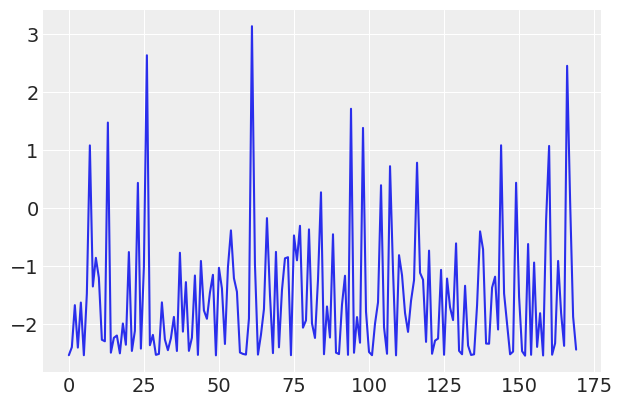

In [19]:
m_8_3_loo = az.loo(m_8_3_trace, pointwise=True)

plt.plot(m_8_3_loo.loo_i)

#### Code 8.17

In [20]:
with m_8_3:
    m_8_3_posterior = pm.sample_posterior_predictive(m_8_3_trace, vars=[a, b])

100%|██████████| 1000/1000 [00:00<00:00, 9276.89it/s]


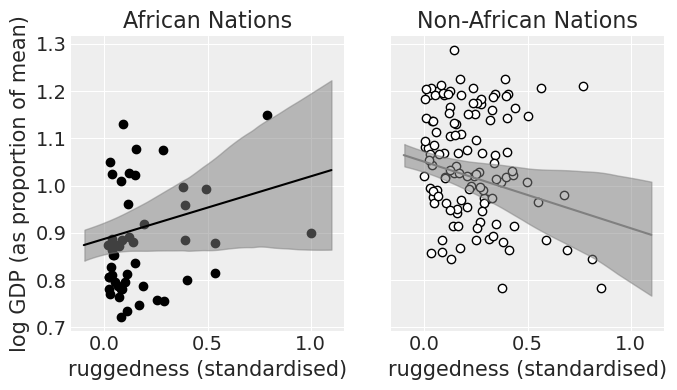

In [21]:
fig, axs = plt.subplots(1, 2, figsize=[7, 4], sharey=True)

ax1, ax0 = axs

rugged_plot = np.linspace(-0.1, 1.1)

ax0.scatter(
    dd.loc[cid == 0, "rugged_std"],
    dd.loc[cid == 0, "log_gdp_std"],
    label="Not Africa",
    facecolor="w",
    lw=1,
    edgecolor="k",
)
# calculating predicted manually because this is a pain with categorical variabiles in PyMC3
pred0 = (
    m_8_3_posterior["a"][:, 0] + rugged_plot.reshape(-1, 1) * m_8_3_posterior["b"][:, 0]
)
ax0.plot(rugged_plot, pred0.mean(1), color="grey")
az.plot_hpd(rugged_plot, pred0.T, color="grey", credible_interval=0.97, ax=ax0)
ax0.set_title("Non-African Nations")

ax1.scatter(
    dd.loc[cid == 1, "rugged_std"],
    dd.loc[cid == 1, "log_gdp_std"],
    label="Africa",
    color="k",
)
# calculating predicted manually because this is a pain with categorical variabiles in PyMC3
pred1 = (
    m_8_3_posterior["a"][:, 1] + rugged_plot.reshape(-1, 1) * m_8_3_posterior["b"][:, 1]
)
ax1.plot(rugged_plot, pred1.mean(1), color="k")
az.plot_hpd(rugged_plot, pred1.T, color="grey", credible_interval=0.97, ax=ax1)
ax1.set_title("African Nations")


ax.set_xlim(-0.1, 1.1)
ax0.set_xlabel("ruggedness (standardised)")
ax1.set_xlabel("ruggedness (standardised)")
ax1.set_ylabel("log GDP (as proportion of mean)")

fig.tight_layout()

#### Code 8.18

(0.0, 1.0)

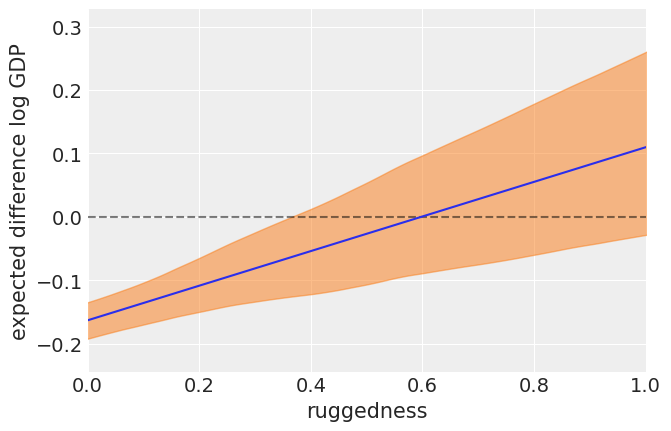

In [22]:
rugged_plot = np.linspace(-0.1, 1.1)

delta = pred1 - pred0  # using 'pred' from above

plt.plot(rugged_plot, delta.mean(1))
az.plot_hpd(rugged_plot, delta.T)

plt.axhline(0, ls="dashed", zorder=1, color=(0, 0, 0, 0.5))
plt.xlabel("ruggedness")
plt.ylabel("expected difference log GDP")
plt.xlim(0, 1)

These numbers are quite different from the book - not sure why.

#### Code 8.19

In [23]:
d = pd.read_csv("Data/tulips.csv", delimiter=";")
d.head()

,bed,water,shade,blooms
0,a,1,1,0.00
1,a,1,2,0.00
2,a,1,3,111.04
3,a,2,1,183.47
4,a,2,2,59.16


#### Code 8.20

In [24]:
d["blooms_std"] = d["blooms"] / d["blooms"].max()
d["water_cent"] = d["water"] - d["water"].mean()
d["shade_cent"] = d["shade"] - d["shade"].mean()

#### Code 8.21

In [25]:
a = stats.norm.rvs(0.5, 1, 10000)
sum((a < 0) | (a > 1)) / len(a)

0.6249

#### Code 8.22

In [26]:
a = stats.norm.rvs(0.5, 0.25, 10000)
sum((a < 0) | (a > 1)) / len(a)

0.0462

#### Code 8.23

In [27]:
with pm.Model() as m_8_4:
    a = pm.Normal("a", 0.5, 0.25)
    bw = pm.Normal("bw", 0, 0.25)
    bs = pm.Normal("bs", 0, 0.25)

    mu = a + bw * d["water_cent"] + bs * d["shade_cent"]
    sigma = pm.Exponential("sigma", 1)

    blooms_std = pm.Normal("blooms_std", mu, sigma, observed=d["blooms_std"])

    m_8_4_trace = pm.sample()
    m_8_4_post = pm.sample_posterior_predictive(m_8_4_trace, vars=[a, bw, bs])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bs, bw, a]
100%|██████████| 1000/1000 [00:00<00:00, 10318.75it/s]


#### Code 8.24

In [28]:
with pm.Model() as m_8_5:
    a = pm.Normal("a", 0.5, 0.25)
    bw = pm.Normal("bw", 0, 0.25)
    bs = pm.Normal("bs", 0, 0.25)
    bws = pm.Normal("bws", 0, 0.25)

    mu = (
        a
        + bw * d["water_cent"]
        + bs * d["shade_cent"]
        + bws * d["water_cent"] * d["shade_cent"]
    )
    sigma = pm.Exponential("sigma", 1)

    blooms_std = pm.Normal("blooms_std", mu, sigma, observed=d["blooms_std"])

    m_8_5_trace = pm.sample()
    m_8_5_post = pm.sample_posterior_predictive(m_8_5_trace, vars=[a, bw, bs, bws])

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, bws, bs, bw, a]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:02<00:00, 833.64draws/s]
The acceptance probability does not match the target. It is 0.8819097065178743, but should be close to 0.8. Try to increase the number of tuning steps.
100%|██████████| 1000/1000 [00:00<00:00, 14799.94it/s]


#### Code 8.25

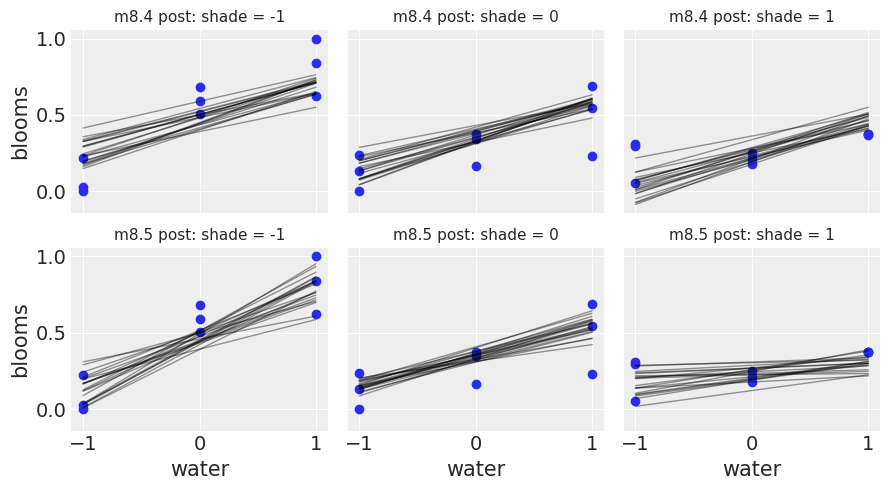

In [30]:
fig, axs = plt.subplots(2, 3, figsize=[9, 5], sharey=True, sharex=True)

n_lines = 20
pred_x = np.array([-1, 1])

for i, shade in enumerate([-1, 0, 1]):
    ind = d.shade_cent == shade
    for ax in axs[:, i]:
        ax.scatter(d.loc[ind, "water_cent"], d.loc[ind, "blooms_std"])
    # top row, m_8_4
    ax = axs[0, i]
    ax.set_title(f"m8.4 post: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        m_8_4_post["a"][:n_lines]
        + m_8_4_post["bw"][:n_lines] * pred_x.reshape(-1, 1)
        + m_8_4_post["bs"][:n_lines] * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))

    # bottom row, m_8_5
    ax = axs[1, i]
    ax.set_title(f"m8.5 post: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        m_8_5_post["a"][:n_lines]
        + m_8_5_post["bw"][:n_lines] * pred_x.reshape(-1, 1)
        + m_8_5_post["bs"][:n_lines] * shade
        + m_8_5_post["bws"][:n_lines] * pred_x.reshape(-1, 1) * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))

for ax in axs.flat:
    if ax.is_first_col():
        ax.set_ylabel("blooms")
    if ax.is_last_row():
        ax.set_xlabel("water")

fig.tight_layout()

#### Code 8.26

In [31]:
with m_8_4:
    m_8_4_priors = pm.sample_prior_predictive(vars=["a", "bw", "bs"])

with m_8_5:
    m_8_5_priors = pm.sample_prior_predictive(vars=["a", "bw", "bs", "bws"])

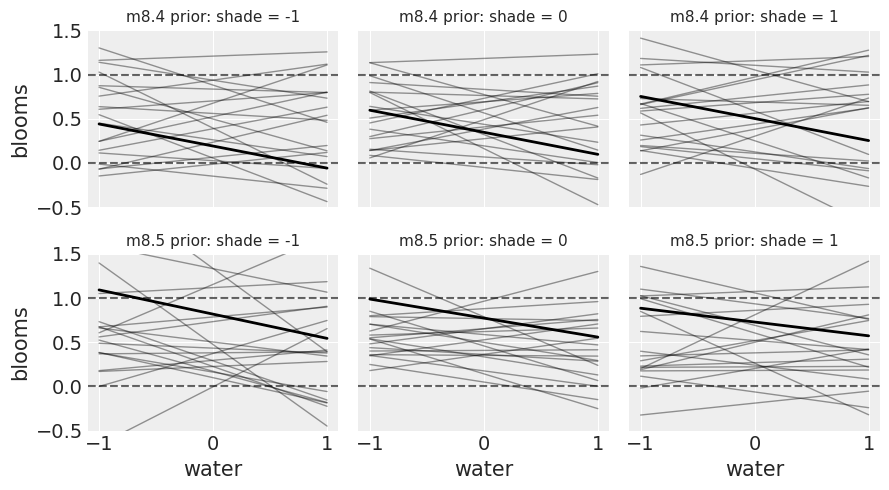

In [32]:
fig, axs = plt.subplots(2, 3, figsize=[9, 5], sharey=True, sharex=True)

n_lines = 20
pred_x = np.array([-1, 1])

for i, shade in enumerate([-1, 0, 1]):
    # top row, m_8_4
    ax = axs[0, i]
    ax.set_title(f"m8.4 prior: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        m_8_4_priors["a"][:n_lines]
        + m_8_4_priors["bw"][:n_lines] * pred_x.reshape(-1, 1)
        + m_8_4_priors["bs"][:n_lines] * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))
    ax.plot(pred_x, pred_y[:, 0], lw=2, color="k")

    # bottom row, m_8_5
    ax = axs[1, i]
    ax.set_title(f"m8.5 prior: shade = {shade:.0f}", fontsize=11)
    pred_y = (
        m_8_5_priors["a"][:n_lines]
        + m_8_5_priors["bw"][:n_lines] * pred_x.reshape(-1, 1)
        + m_8_5_priors["bs"][:n_lines] * shade
        + m_8_5_priors["bws"][:n_lines] * pred_x.reshape(-1, 1) * shade
    )
    ax.plot(pred_x, pred_y, lw=1, color=(0, 0, 0, 0.4))
    ax.plot(pred_x, pred_y[:, 0], lw=2, color="k")

for ax in axs.flat:
    ax.set_ylim(-0.5, 1.5)
    ax.axhline(1, ls="dashed", color=(0, 0, 0, 0.6))
    ax.axhline(0, ls="dashed", color=(0, 0, 0, 0.6))
    if ax.is_first_col():
        ax.set_ylabel("blooms")
    if ax.is_last_row():
        ax.set_xlabel("water")

fig.tight_layout()

In [33]:
%load_ext watermark
%watermark -n -u -v -iv -w

pymc3  3.8
pandas 1.0.3
numpy  1.18.1
arviz  0.7.0
last updated: Tue May 19 2020 

CPython 3.7.6
IPython 7.13.0
watermark 2.0.2
